In [1]:
import gym
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive/


# Environment

In [3]:
# Create the Taxi-v3 environment
env = gym.make("Taxi-v3", render_mode='ansi')

# Define the directory containing the files
directory = '/content/drive/MyDrive/RML/KA/q_tables'  # Change this to the directory containing your files if different

# Get all files in the directory
q_table_files = os.listdir(directory)

# Filter files that start with 'q_table_'
# q_table_files = [file for file in all_files if file.startswith('q_table_')]

# Evaluate each Q-table
best_performance = float('inf')
best_q_table = None
best_hyperparameters = None
q_table_files = sorted(q_table_files)[::-1]
# q_table_files

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
# Extract time from filename
time_list = []
for filename in q_table_files:
  time_str = re.findall(r'\d+', filename)[-2]
  time_list.append(int(time_str))

# Sort by time and select top 10
time_list, q_table_files = zip(*sorted(zip(time_list, q_table_files)))
top_10_files = q_table_files[:10]

top_10_files

('q_table_10000_0.05_37.00477051734924_3127.npy',
 'q_table_1000_0.3_2.002225399017334_1020.npy',
 'q_table_10000_0.1_15.003557920455933_711.npy',
 'q_table_5000_0.6_8.4308443069458_3860.npy',
 'q_table_5000_0.15_6.9029541015625_726.npy',
 'q_table_10000_0.9_19.09778070449829_11371.npy',
 'q_table_1000_0.2_2.010862112045288_666.npy',
 'q_table_5000_0.85_10.12311577796936_9068.npy',
 'q_table_100_0.05_2.12605619430542_1179.npy',
 'q_table_10000_0.6_16.17503023147583_3932.npy')

In [5]:
dict_of_score = {}

for file in q_table_files:
    # Extract the number of epochs from the file name
    epochs = int(re.findall(r'\d+', file)[0])

    # Initialize an empty dictionary for the current number of epochs
    dict_of_score[epochs] = {}

dict_of_score

{10000: {},
 1000: {},
 5000: {},
 100: {},
 200: {},
 2000: {},
 50: {},
 10: {},
 5: {}}

Testing Q tables

In [6]:
# Track total penalties and moves
total_penalties = 0
total_moves = 0
all_scores = []

for file_name in sorted(q_table_files):
    q_table = np.load(os.path.join(directory, file_name))
    total_penalties = 0
    total_moves = 0  # Initialize total moves
    num_episodes = 100

    # Extract hyperparameters from the file name
    parts = file_name.split("_")
    epochs = int(parts[2])
    epsilon = float(parts[3])

    # if epochs >= 10:
    #     break
    start_time = time.time()

    for _ in range(num_episodes):
        state = env.reset()
        penalties = 0
        moves = 0  # Initialize moves for each episode
        done = False

        while not done:
            action = np.argmax(q_table[state])
            state, reward, done, _ = env.step(action)
            moves += 1  # Increment moves for each action

            if reward == -10:
                penalties += 1

        total_moves += moves  # Accumulate moves for all episodes
        total_penalties += penalties

    end_time = time.time()
    testing_time = end_time - start_time

    avg_testing_time = testing_time / num_episodes
    avg_moves = total_moves / (num_episodes * len(q_table_files))  # Calculate average moves per episode
    avg_penalties = total_penalties / num_episodes  # Calculate average penalties per episode

    dict_of_score[epochs][epsilon] = (total_moves, avg_penalties, avg_testing_time)

    print(f"Epochs: {epochs}, Epsilon: {epsilon}, Avg Moves: {avg_moves}, Avg Penalties: {avg_penalties}, Avg Testing Time: {avg_testing_time}")

    # Update best performance and best Q-table if necessary
    if avg_moves <= best_performance:
        best_performance = avg_moves
        best_q_table = q_table
        best_hyperparameters = {
            "epochs": epochs,
            "epsilon": epsilon
        }

print(f"\nBest Q-table: Avg Moves: {best_performance}, Epochs: {best_hyperparameters['epochs']}, Epsilon: {best_hyperparameters['epsilon']}")

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Epochs: 10000, Epsilon: 0.05, Avg Moves: 0.20555555555555555, Avg Penalties: 0.0, Avg Testing Time: 0.002150695323944092
Epochs: 10000, Epsilon: 0.15, Avg Moves: 0.07188888888888889, Avg Penalties: 0.0, Avg Testing Time: 0.001949927806854248
Epochs: 10000, Epsilon: 0.1, Avg Moves: 0.07277777777777777, Avg Penalties: 0.0, Avg Testing Time: 0.001510753631591797
Epochs: 10000, Epsilon: 0.25, Avg Moves: 0.07333333333333333, Avg Penalties: 0.0, Avg Testing Time: 0.0016322970390319825
Epochs: 10000, Epsilon: 0.2, Avg Moves: 0.07216666666666667, Avg Penalties: 0.0, Avg Testing Time: 0.0011747884750366211
Epochs: 10000, Epsilon: 0.35, Avg Moves: 0.0735, Avg Penalties: 0.0, Avg Testing Time: 0.0010213303565979005
Epochs: 10000, Epsilon: 0.3, Avg Moves: 0.07283333333333333, Avg Penalties: 0.0, Avg Testing Time: 0.0009681391716003418
Epochs: 10000, Epsilon: 0.45, Avg Moves: 0.07477777777777778, Avg Penalties: 0.0, Avg Testing Time: 0.0011860775947570802
Epochs: 10000, Epsilon: 0.4, Avg Moves: 0.0

# Visusalization

Dependence of Average Penalties on Epsilon for Different Epochs

In [ ]:
colors = ['#1C1678', '#074173', '#1679AB', '#40A2E3', '#5DEBD7', '#0D9276', '#8576FF', '#874CCC', '#FB9AD1']

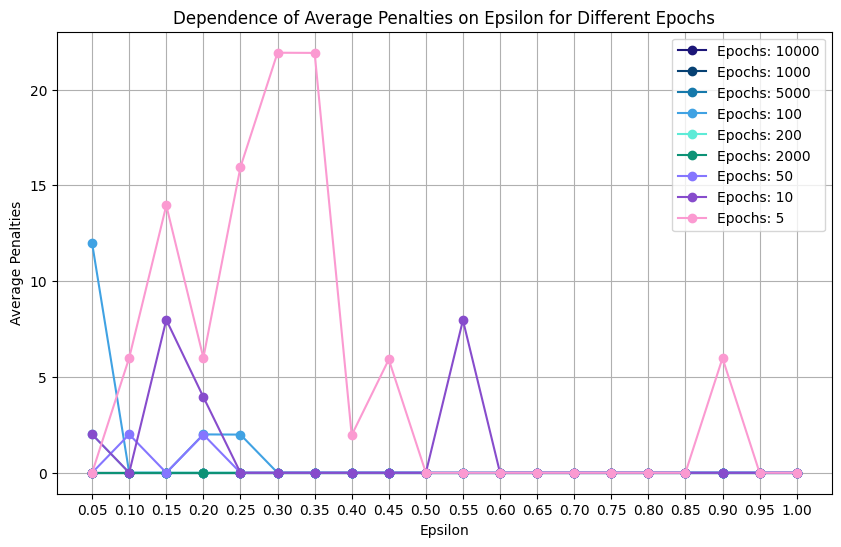

In [ ]:
plt.figure(figsize=(10, 6))
i = 0
for epochs, epsilon_scores in dict_of_score.items():
    # Sort epsilon and scores
    sorted_epsilon_scores = sorted(epsilon_scores.items(), key=lambda item: item[0])

    # Extract epsilon and scores
    epsilon_values = [item[0] for item in sorted_epsilon_scores]
    scores = [item[1][1] for item in sorted_epsilon_scores]

    # Plot the data
    plt.plot(epsilon_values, scores, label=f"Epochs: {epochs}", marker='o', color=colors[i])
    i+=1

plt.xlabel("Epsilon")
plt.xticks(epsilon_values, rotation=0)
plt.ylabel("Average Penalties")
plt.title("Dependence of Average Penalties on Epsilon for Different Epochs")
plt.legend()
plt.grid()
plt.show()

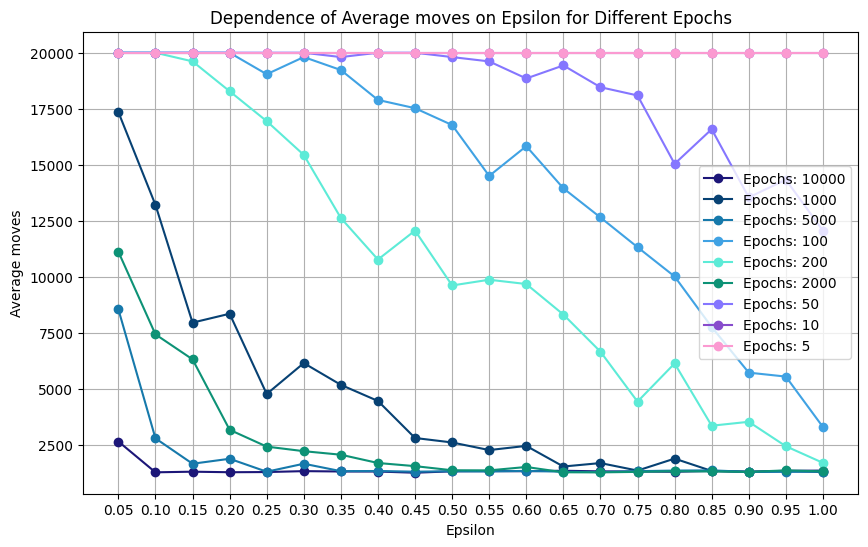

In [ ]:
plt.figure(figsize=(10, 6))
i = 0
for epochs, epsilon_scores in dict_of_score.items():
    sorted_epsilon_scores = sorted(epsilon_scores.items(), key=lambda item: item[0])

    epsilon_values = [item[0] for item in sorted_epsilon_scores]
    scores = [item[1][0] for item in sorted_epsilon_scores]

    plt.plot(epsilon_values, scores, label=f"Epochs: {epochs}", marker='o', color=colors[i])
    i+=1


plt.xlabel("Epsilon")
plt.xticks(epsilon_values, rotation=0)
plt.ylabel("Average moves")
plt.title("Dependence of Average moves on Epsilon for Different Epochs")
plt.legend()
plt.grid()
plt.show()

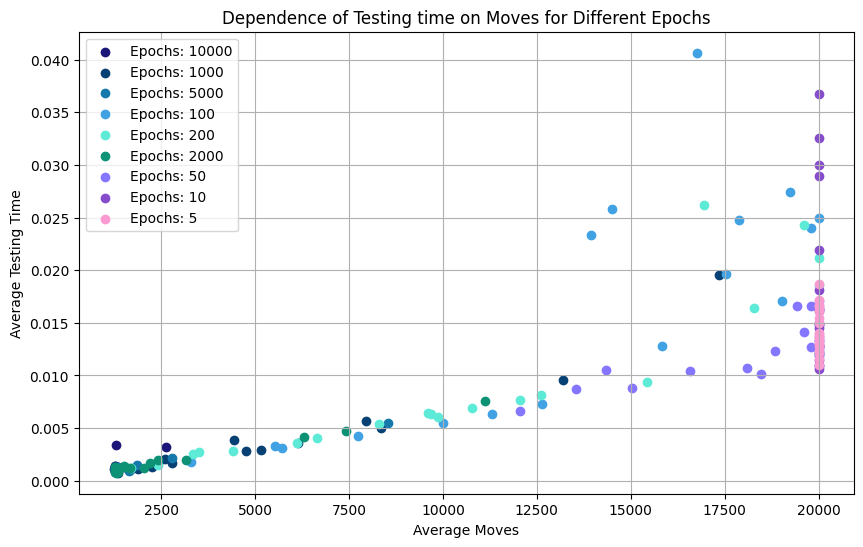

In [ ]:
plt.figure(figsize=(10, 6))
i = 0
for epochs, epsilon_scores in dict_of_score.items():
    # Sort epsilon and scores
    sorted_epsilon_scores = sorted(epsilon_scores.items(), key=lambda item: item[0])

    # Extract epsilon and scores
    avg_moves = [item[1][0] for item in sorted_epsilon_scores]
    avg_testing_time = [item[1][2] for item in sorted_epsilon_scores]

    # Plot the data
    plt.scatter(avg_moves, avg_testing_time, label=f"Epochs: {epochs}", marker='o', color=colors[i])
    i+=1

plt.xlabel("Average Moves")
# plt.xticks([item[1][2] for item in sorted_epsilon_scores], rotation=0)
plt.ylabel("Average Testing Time")
plt.title("Dependence of Testing time on Moves for Different Epochs")
plt.legend()
plt.grid()
plt.show()

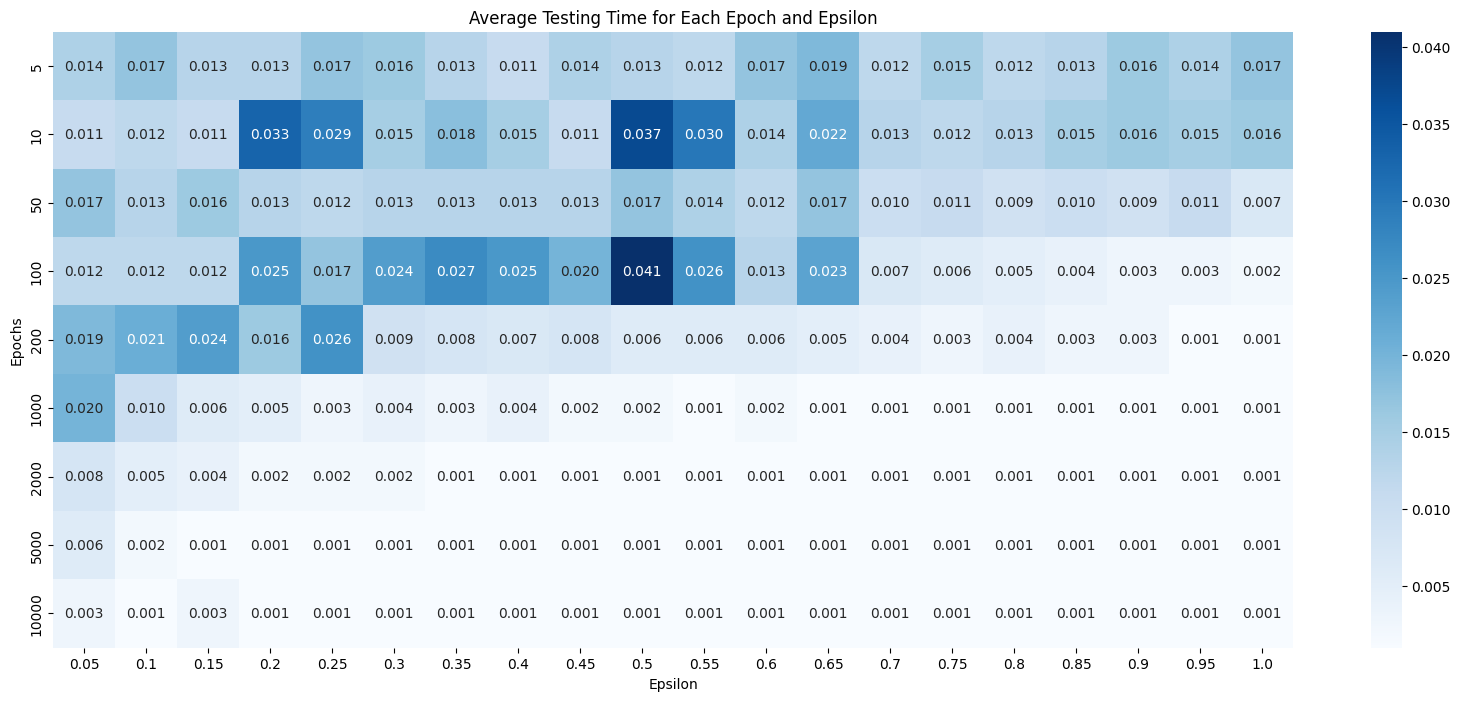

In [ ]:
data = []
for epochs, epsilons in dict_of_score.items():
    for epsilon, scores in epsilons.items():
        avg_testing_time = scores[2]
        data.append([epochs, epsilon, round(avg_testing_time, 3)])

df = pd.DataFrame(data, columns=['Epochs', 'Epsilon', 'Avg Testing Time'])
# Create heatmap
plt.figure(figsize=(20, 8))
heatmap_data = df.pivot(index='Epochs', columns='Epsilon', values='Avg Testing Time', )
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="Blues")
plt.title('Average Testing Time for Each Epoch and Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Epochs')
plt.show()

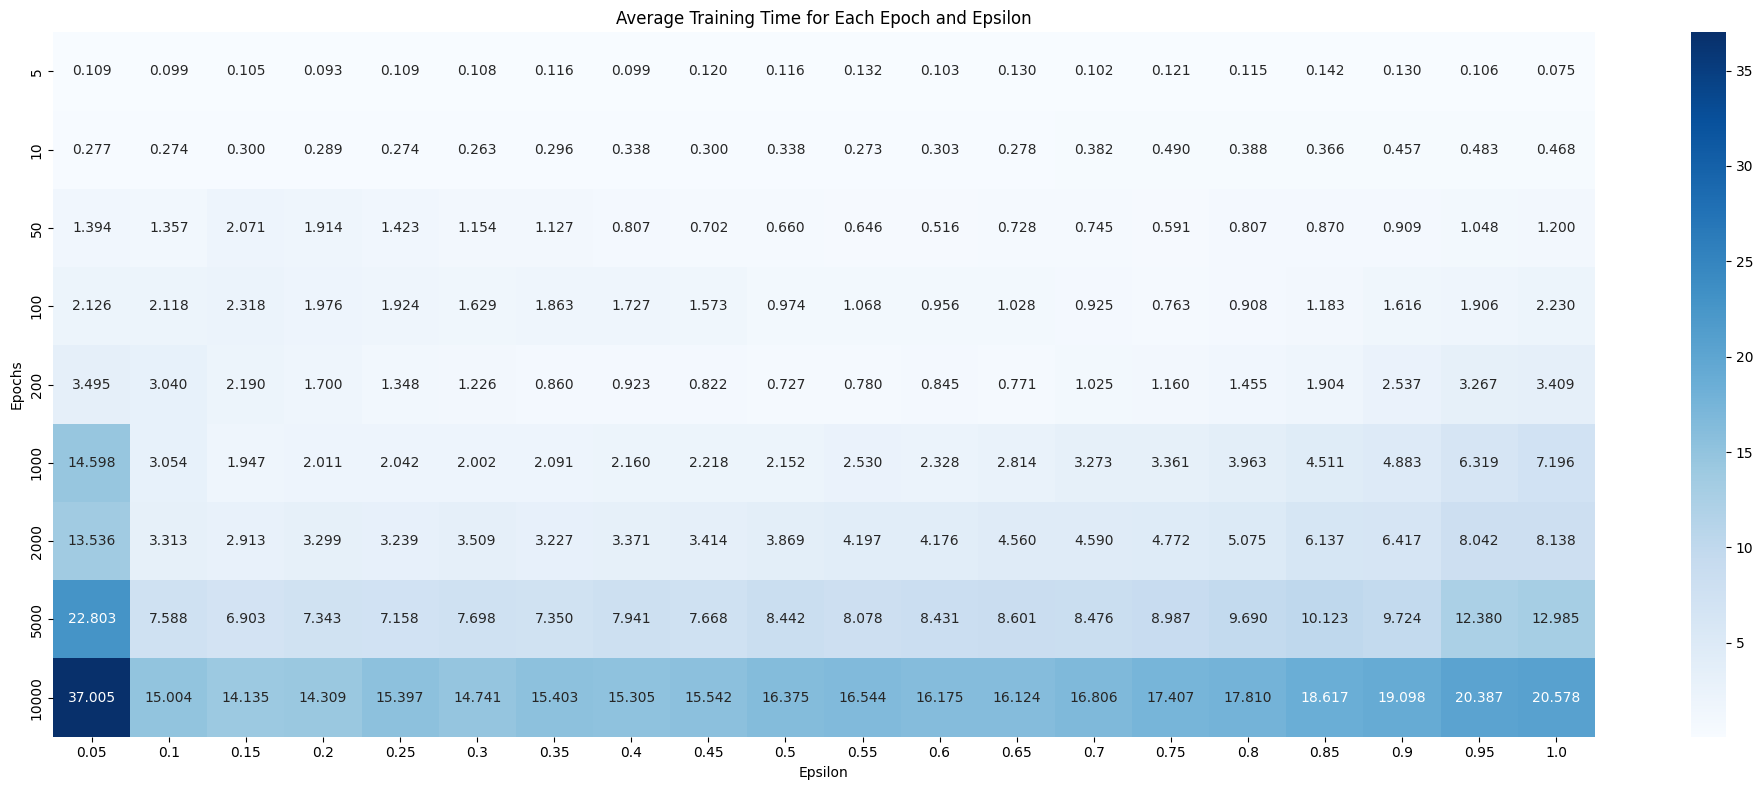

In [ ]:
data = []
for file_name in sorted(q_table_files):
    parts = file_name.split("_")
    epochs = int(parts[2])
    epsilon = float(parts[3])
    avg_training_time = float(parts[-2])
    data.append([epochs, epsilon, round(avg_training_time, 4)])

df = pd.DataFrame(data, columns=['Epochs', 'Epsilon', 'Avg Training Time'])

plt.figure(figsize=(20, 8))
heatmap_data_train = df.pivot(index='Epochs', columns='Epsilon', values='Avg Training Time')
sns.heatmap(heatmap_data_train, annot=True, fmt=".3f", cmap="Blues")
plt.title('Average Training Time for Each Epoch and Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Epochs')

plt.tight_layout()
plt.show()

Taxi visualization for the best Q table

In [ ]:
import time
from IPython.display import clear_output

In [ ]:
# Reset environment to start a new episode
state = env.reset()
total_reward = 0
frames = []


while True:
    # Choose the action with the highest Q-value for the current state
    action = np.argmax(best_q_table[state])

    # Take the action
    new_state, reward, done, _ = env.step(action)

    # Accumulate the reward
    total_reward += reward

    # Render the current state
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    # If episode is finished, break the loop
    if done:
        break

    # Update state for the next step
    state = new_state

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [ ]:
for i, frame in enumerate(frames):
    print(frame['frame'][0])
    print(f"Timestep: {i + 1}")
    print(f"Action: {frame['action']}")
    print(f"Reward: {frame['reward']}")
    print("=============")
    clear_output(wait=True)
    time.sleep(1)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 12
Action: 5
Reward: 20
